In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
target_behaviour = pd.read_csv("../../target_behaviour_identification.csv")
CompositeQualityScore = pd.read_csv("user_metrics_withCompositeQualityScore.csv")
topic_assigned = pd.read_csv("../topics_assigned.csv")

## Distribution of different experiemnt setting

In [24]:
target_behaviour['category'].value_counts()

category
less procrastination    99
healthier eating        49
sustainable living      12
Name: count, dtype: int64

In [25]:
target_behaviour[target_behaviour['condition'] == 'framework']['category'].value_counts()

category
less procrastination    52
healthier eating        27
sustainable living       2
Name: count, dtype: int64

In [26]:
target_behaviour[target_behaviour['condition'] == 'no_system']['category'].value_counts()

category
less procrastination    47
healthier eating        22
sustainable living      10
Name: count, dtype: int64

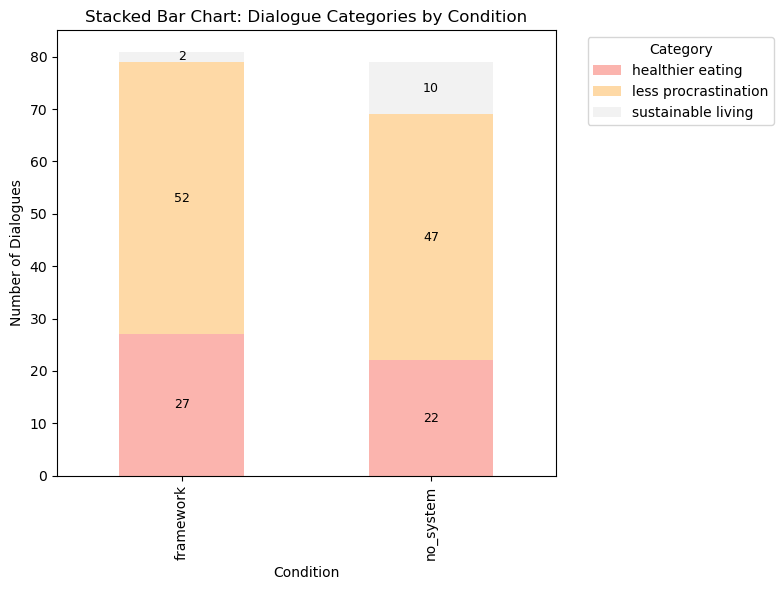

In [27]:
data = {
    'condition': ['framework'] * 3 + ['no_system'] * 3,
    'category': ['less procrastination', 'healthier eating', 'sustainable living'] * 2,
    'count': [52, 27, 2, 47, 22, 10]
}

df = pd.DataFrame(data)


pivot_df = df.pivot(index='condition', columns='category', values='count').fillna(0)


ax = pivot_df.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='Pastel1')


for c_idx, condition in enumerate(pivot_df.index):
    y_offset = 0
    for cat in pivot_df.columns:
        value = pivot_df.loc[condition, cat]
        if value > 0:
            ax.text(c_idx, y_offset + value / 2, int(value), ha='center', va='center', fontsize=9)
            y_offset += value

plt.title("Stacked Bar Chart: Dialogue Categories by Condition")
plt.ylabel("Number of Dialogues")
plt.xlabel("Condition")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Combine necessary columns from three csv files

In [28]:
df_main = target_behaviour.merge(
    CompositeQualityScore[['chat_id', 'Readiness to Change (Delta)']],
    on='chat_id',
    how='left'  
)

In [29]:
df_main = df_main.merge(
    topic_assigned[['chat_id', 'topic']],
    on='chat_id',
    how='left'  
)

In [30]:
df_main.head()

,chat_id,combined_text,category,user_utterance_english,bot_utterance_english,condition,Readiness to Change (Delta),topic
0,1.0,"Start Hi! I'm MIcha, your motivational chatbot. My goal is to help you reflect on your behavior and help you develop a plan for your behavioral change. Please think carefully about my questions and see them primarily as thought impulses that bring you mentally closer to your goal. I'm not here to give you tips or recommendations for action, but to get clear about your motives and values. What behavioral change do you want to talk about today? I want to procrastinate less So you want to procrastinate less. Can you tell me something about why this change is important to you? I could be a lot further in my life. How important is this change on a scale from 0 (not at all) to 10 (very) I don't know. On a scale from 0 (not at all) to 10 (very), how interested are you in doing this change right now? 8 An 8. So you're positive about this change overall. Can you tell me a little more about this assessment? Why didn't you give a higher or lower value? Because I have to change something now, but I've told myself that many times, so only eight. That sounds like you've often felt the impulse to change something, but then you haven't. What prevents you from putting the desired change into action? Everyday life, laziness. It seems as if everyday life and laziness are obstacles for you. How could it be if you overcome these obstacles? That would be very nice and an improvement in my living quality. It sounds like you want a higher quality of life and think that less procrastination could contribute to it. Are there other aspects you want to improve if you procrastinate less? Spend more time with friends and family. So you would like to spend more time with your loved ones if you were to procrastinate less. How much do you think this change would help to spend more time with friends and family? Think very strongly, since I spend a lot of time with Daddelei. So you strongly believe that less procrastination would give you more time with your friends and family, as you spend a lot of time with ""daddy"" right now. You feel ready for a change and you feel that you have to change something now, even though you've told yourself that many times. You admit that everyday life and laziness are obstacles to you, but you also see the potential for an improved quality of life and more time with the people you care about. Have I forgotten something yet? Nope. Please tell me again what your next step will be concrete. I thought you'd tell me. Thank you for your openness in our conversation. I hope it helped you at least to get a little closer to your goal.",less procrastination,"Start I want to procrastinate less I could be a lot further in my life. I don't know. 8 Because I have to change something now, but I've told myself that many times, so only eight. Everyday life, laziness. That would be very nice and an improvement in my living quality. Spend more time with friends and family. Think very strongly, since I spend a lot of time with Daddelei. Nope. I thought you'd tell me.","Hi! I'm MIcha, your motivational chatbot. My goal is to help you reflect on your behavior and help you develop a plan for your behavioral change. Please think carefully about my questions and see them primarily as thought impulses that bring you mentally closer to your goal. I'm not here to give you tips or recommendations for action, but to get clear about your motives and values. What behavioral change do you want to talk about today? So you want to procrastinate less. Can you tell me something about why this change is important to you? How important is this change on a scale from 0 (not at all) to 10 (very) On a scale from 0 (not at all) to 10 (very), how interested are you in doing this change right now? An 8. So you're positive about this change overall. Can you tell me a little more about this assessment? Why didn't you give a higher or lower value? 

## Generate a new column called *quality_label*, we devide the dialogues into high_score group and low_score group on each different experiment setting.

In [32]:
# Create a new column to store high/low quality labels
df_main['quality_label'] = None

# For each group, split dialogues into high/low quality based on the median quality_score
for (cond, cat), group in df_main.groupby(['condition', 'category']):
    median = group['Readiness to Change (Delta)'].median()
    high_ids = group[group['Readiness to Change (Delta)'] > median]['chat_id']
    
    df_main.loc[df_main['chat_id'].isin(high_ids), 'quality_label'] = 'high_score'
    df_main.loc[(df_main['chat_id'].isin(group['chat_id'])) & (~df_main['chat_id'].isin(high_ids)), 'quality_label'] = 'low_score'


In [33]:
df_main.head()

,chat_id,combined_text,category,user_utterance_english,bot_utterance_english,condition,Readiness to Change (Delta),topic,quality_label
0,1.0,"Start Hi! I'm MIcha, your motivational chatbot. My goal is to help you reflect on your behavior and help you develop a plan for your behavioral change. Please think carefully about my questions and see them primarily as thought impulses that bring you mentally closer to your goal. I'm not here to give you tips or recommendations for action, but to get clear about your motives and values. What behavioral change do you want to talk about today? I want to procrastinate less So you want to procrastinate less. Can you tell me something about why this change is important to you? I could be a lot further in my life. How important is this change on a scale from 0 (not at all) to 10 (very) I don't know. On a scale from 0 (not at all) to 10 (very), how interested are you in doing this change right now? 8 An 8. So you're positive about this change overall. Can you tell me a little more about this assessment? Why didn't you give a higher or lower value? Because I have to change something now, but I've told myself that many times, so only eight. That sounds like you've often felt the impulse to change something, but then you haven't. What prevents you from putting the desired change into action? Everyday life, laziness. It seems as if everyday life and laziness are obstacles for you. How could it be if you overcome these obstacles? That would be very nice and an improvement in my living quality. It sounds like you want a higher quality of life and think that less procrastination could contribute to it. Are there other aspects you want to improve if you procrastinate less? Spend more time with friends and family. So you would like to spend more time with your loved ones if you were to procrastinate less. How much do you think this change would help to spend more time with friends and family? Think very strongly, since I spend a lot of time with Daddelei. So you strongly believe that less procrastination would give you more time with your friends and family, as you spend a lot of time with ""daddy"" right now. You feel ready for a change and you feel that you have to change something now, even though you've told yourself that many times. You admit that everyday life and laziness are obstacles to you, but you also see the potential for an improved quality of life and more time with the people you care about. Have I forgotten something yet? Nope. Please tell me again what your next step will be concrete. I thought you'd tell me. Thank you for your openness in our conversation. I hope it helped you at least to get a little closer to your goal.",less procrastination,"Start I want to procrastinate less I could be a lot further in my life. I don't know. 8 Because I have to change something now, but I've told myself that many times, so only eight. Everyday life, laziness. That would be very nice and an improvement in my living quality. Spend more time with friends and family. Think very strongly, since I spend a lot of time with Daddelei. Nope. I thought you'd tell me.","Hi! I'm MIcha, your motivational chatbot. My goal is to help you reflect on your behavior and help you develop a plan for your behavioral change. Please think carefully about my questions and see them primarily as thought impulses that bring you mentally closer to your goal. I'm not here to give you tips or recommendations for action, but to get clear about your motives and values. What behavioral change do you want to talk about today? So you want to procrastinate less. Can you tell me something about why this change is important to you? How important is this change on a scale from 0 (not at all) to 10 (very) On a scale from 0 (not at all) to 10 (very), how interested are you in doing this change right now? An 8. So you're positive about this change overall. Can you tell me a little more about this assessment? Why didn't you give a higher or

In [34]:
pd.set_option('display.max_colwidth', None)
df_main.query("topic=='ADHD'")["combined_text"]

256                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Start Hi! I'm MIcha, your motivational chatbot. My goal is to help you reflect on your behavior and hel

In [35]:
df_main.query("topic=='ADHD'")["quality_label"]

256    high_score
307     low_score
Name: quality_label, dtype: object

## Count the distribution of each topic in high- and low-quality dialogues.

In [36]:
# Group by condition, category, quality_label, and topic, and count the number of occurrences
topic_dist = (
    df_main.groupby(['condition', 'category', 'quality_label', 'topic'])
    .size()
    .reset_index(name='count')
)

In [37]:
topic_dist

,condition,category,quality_label,topic,count
0,framework,healthier eating,high_score,Behavioral Change,1
1,framework,healthier eating,high_score,Emotional Connection to Food,2
2,framework,healthier eating,high_score,Fear of Failure,1
3,framework,healthier eating,high_score,Goal Setting,2
4,framework,healthier eating,high_score,Healthy Eating,8
...,...,...,...,...,...
111,no_system,sustainable living,low_score,Self-Reflection,5
112,no_system,sustainable living,low_score,Social Media Influence,1
113,no_system,sustainable living,low_score,Support System,1
114,no_system,sustainable living,low_score,Sustainability,4


## Visualisation the distribution topics in high- and low-quality dialogues in each different experiment setting.

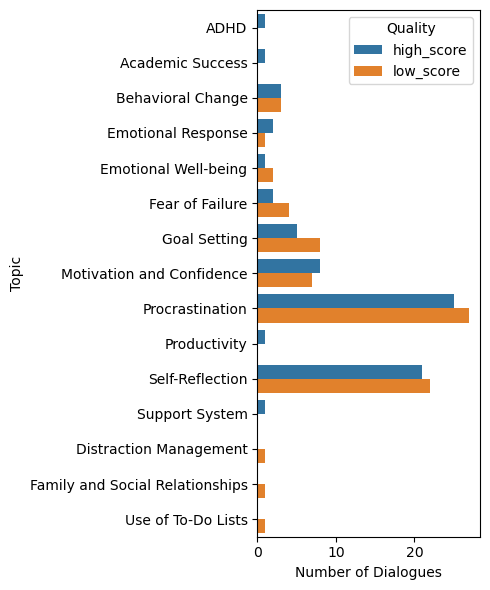

In [38]:
# Get all unique (condition, category) pairs to iterate over
group_keys = topic_dist[['condition', 'category']].drop_duplicates()

# # Loop through each condition + category combination
for _, row in group_keys.iterrows():
    cond = row['condition']
    cat = row['category']
    #print(type(cond))
    #print(cat)
    if (cond == "framework")  & (cat == "less procrastination"):
      # # Filter topic distribution data for this subgroup
      subset = topic_dist[(topic_dist['condition'] == cond) & (topic_dist['category'] == cat)]

      top_topics = subset.groupby('topic')['count'].sum().sort_values(ascending=False).index
      subset = subset[subset['topic'].isin(top_topics)]
      plt.figure(figsize=(5, max(6, len(top_topics) * 0.4)))
      sns.barplot(data=subset, x='count', y='topic', hue='quality_label')
      #plt.title(f'Topic Distribution in "{cond} - {cat}"')
      plt.xlabel("Number of Dialogues")
      plt.ylabel("Topic")
      plt.legend(title='Quality')
      plt.tight_layout()
      #plt.show()
      plt.savefig("fig1.png",dpi=199)

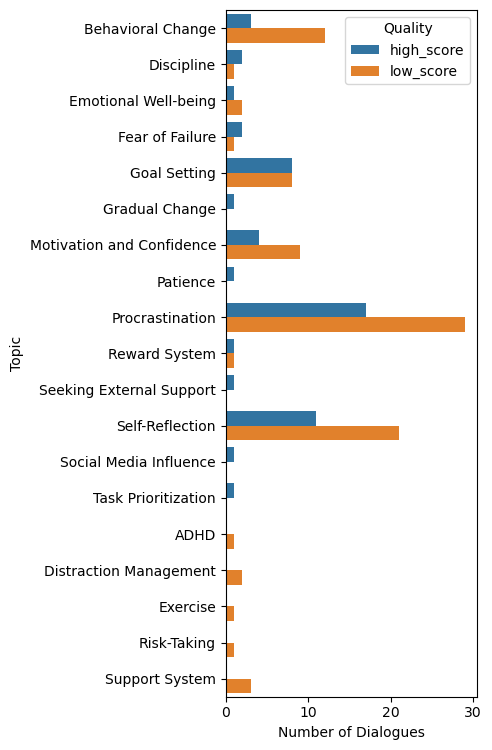

In [39]:
# Get all unique (condition, category) pairs to iterate over
group_keys = topic_dist[['condition', 'category']].drop_duplicates()

# # Loop through each condition + category combination
for _, row in group_keys.iterrows():
    cond = row['condition']
    cat = row['category']
    #print(type(cond))
    #print(cat)
    if (cond == "no_system")  & (cat == "less procrastination"):
      # # Filter topic distribution data for this subgroup
      subset = topic_dist[(topic_dist['condition'] == cond) & (topic_dist['category'] == cat)]

      top_topics = subset.groupby('topic')['count'].sum().sort_values(ascending=False).index
      subset = subset[subset['topic'].isin(top_topics)]
      plt.figure(figsize=(5, max(6, len(top_topics) * 0.4)))
      sns.barplot(data=subset, x='count', y='topic', hue='quality_label')
      #plt.title(f'Topic Distribution in "{cond} - {cat}"')
      plt.xlabel("Number of Dialogues")
      plt.ylabel("Topic")
      plt.legend(title='Quality')
      plt.tight_layout()
      #plt.show()
      plt.savefig("fig2.png",dpi=199)